In [1]:
from binance.client import Client
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import mplcursors
pd.options.mode.chained_assignment = None
import numpy as np
import datetime as dt

In [2]:
client = Client()

def get_historical_klines(symbol, interval, start_str):
    klines = client.get_historical_klines(symbol, interval, start_str)
    df = pd.DataFrame(klines, columns=["Open time", "Open", "High", "Low", "Close", "Volume",
                                      "Close time", "Quote asset volume", "Number of trades",
                                      "Taker buy base asset volume",
                                      "Taker buy quote asset volume", "Ignore"])
    
    df["Date"] = pd.to_datetime(df["Open time"], unit="ms")
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]
    return df

btc_data_orig = get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "1 year ago UTC")

In [3]:
sol_data_orig = get_historical_klines("SOLUSDT", Client.KLINE_INTERVAL_1DAY, "3 years ago UTC")
sol_data_orig.set_index("Date", inplace=True)

In [3]:
btc_data_orig.set_index("Date", inplace=True)


In [4]:
btc = btc_data_orig.copy()
#sol = sol_data_orig.copy()
btc[["Open", "High", "Low", "Close", "Volume"]] = btc[["Open", "High", "Low", "Close", "Volume"]].astype(float)
#sol[["Open", "High", "Low", "Close", "Volume"]] = sol[["Open", "High", "Low", "Close", "Volume"]].astype(float)

In [141]:
#SMA indexing

btc["MA_Short"] = btc["Close"].rolling(window=20).mean()
btc["MA_Long"] = btc["Close"].rolling(window=50).mean()
btc["MA_Trend"] = btc["Close"].rolling(window=200).mean()

btc.dropna(inplace=True)

In [152]:
#EMA indexing

btc["EMA_7"] = btc["Close"].ewm(span=6, adjust=False).mean().shift(1)
btc["EMA_21"] = btc["Close"].ewm(span=21, adjust=False).mean().shift(1)

In [65]:
#ehtologiikan luominen esimerkiksi signaalille

btc["Signal"] = 0
btc["Signal"][btc["MA_Short"] > btc["MA_Long"]] = 1
btc["Signal"][btc["MA_Long"] < btc["MA_Short"]] = -1



In [23]:
#ehtologiikan luominen and-operaattorilla
#huomaa miten .shift(1) funktiolla &-operaattorin oikeanpuoleisella ehdolla verrataan edellisen päivän crossoveria
#tämän päivän arvoon

btc["Crossover"] = (btc["MA_Short"].shift(1) < btc["MA_Long"].shift(1)) & (btc["MA_Short"] > btc["MA_Long"])
btc["Crossover"] = (btc["MA_Short"].shift(1) > btc["MA_Long"].shift(1)) & (btc["MA_Short"] < btc["MA_Long"])



In [56]:
#crossoverin liputtaminen
#huomaa for loopin ja .iloc[i:-1] käyttö

btc_data["Flagged crossover"] = 0

last_crossover = 0

for i in range(1, len(btc_data)):
    if (btc["MA_Short"].iloc[i-1] < btc["MA_Long"].iloc[i-1]) and \
    (btc["MA_Short"].iloc[i] > btc["MA_Long"].iloc[i]):
        if last_crossover != 1:
            btc["Flagged crossover"].iloc[i] = 1
            last_crossover = 1
    
    elif (btc["MA_Short"].iloc[i-1] > btc["MA_Long"].iloc[i-1]) and \
    (btc["MA_Short"].iloc[i] < btc["MA_Long"].iloc[i]):
        if last_crossover != -1:
            btc["Flagged crossover"].iloc[i] = -1
            last_crossover = -1

In [143]:
#resistance-levelien etsiminen, perehdy vähän tohon scipyn find_peaks funktioon

#high peaks funktio
high_peaks, _ = find_peaks(btc["Close"], distance=200)

btc["High peak"] = None

btc.loc[btc.index[high_peaks], "High peak"] = btc["MA_Long"].iloc[high_peaks].values

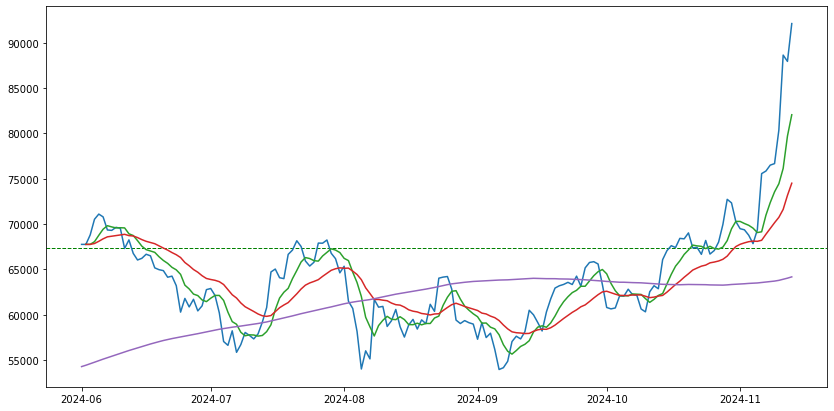

In [154]:
plt.figure(figsize=(14,7))
for level in btc['High peak'].dropna():
    plt.axhline(y=level, color='green', linestyle='--', linewidth=1)


plt.plot(btc["Close"], label="High")
plt.plot(btc["High peak"], label="Peak")
plt.plot(btc["EMA_7"])
plt.plot(btc["EMA_21"])
plt.plot(btc["MA_Trend"])


In [145]:
btc = btc.loc["2024-06-01":]

In [355]:
#vaihtoehtoinen tapa etsiä tuki- ja vastuslinjoja
#tässä btc[<TÄMÄ SISÄLTÖ>] tsekkaa 11 päivän keskiarvon KESKELTÄ ja vertaa missä kohtaa tämä arvo on matalin
#tai korkein seuraavassa solussa

supports = btc[(btc.Low == btc.Low.rolling(window=11, center=True).min())]

In [359]:
resistance = btc[(btc.High == btc.High.rolling(window=11, center=True).max())]

In [327]:
supports = pd.DataFrame(supports.loc[supports["Close"].idxmin()]).T
resistance = pd.DataFrame(resistance.loc[resistance["Close"].idxmax()]).T

In [328]:
supports = pd.Series(supports.min())

In [329]:
resistance = pd.Series(resistance.max())

In [362]:
levels = pd.concat([supports, resistance])

In [ ]:
#filtteröinti tukilinjoille jos jättää enemmän, kokeile vaihtaa arvoa

levels[abs(levels["Close"].diff()) > 2000]

In [508]:
plt.figure(figsize=((14,7)))
btc.High.plot()
btc.Low.plot()
btc.Close.plot()
btc.MA_Short.plot(style="--")
btc.MA_Long.plot(style="--")
#plt.hlines(levels["Close"], xmin=btc.index[0], xmax=btc.index[-1])
plt.hlines(supports["Close"], xmin=btc.index[0], xmax=btc.index[-1], color="red")
plt.hlines(resistance["Close"], xmin=btc.index[0], xmax=btc.index[-1], color="blue")

AttributeError: 'DataFrame' object has no attribute 'High'

<Figure size 1008x504 with 0 Axes>

In [370]:
btc = btc_data_orig.copy()


# regressiosuorien vetoa

In [ ]:
#https://www.youtube.com/watch?v=EMIyRmrPWJQ

In [ ]:
sol = sol["2024-03-13":"2024-11-13"]
btc = btc["2024-03-13":"2024-11-13"]

In [423]:
btc = pd.DataFrame(btc["Close"])
sol = pd.DataFrame(sol["Close"])

In [ ]:
data["SOL"] = data["SOL"].astype(float)
data["BTC"] = data["BTC"].astype(float)

In [426]:
data = pd.merge(btc, sol, left_index=True, right_index=True, suffixes=(" BTC", " SOL"))

In [428]:
data.columns =("BTC", "SOL")

### logaritmi 

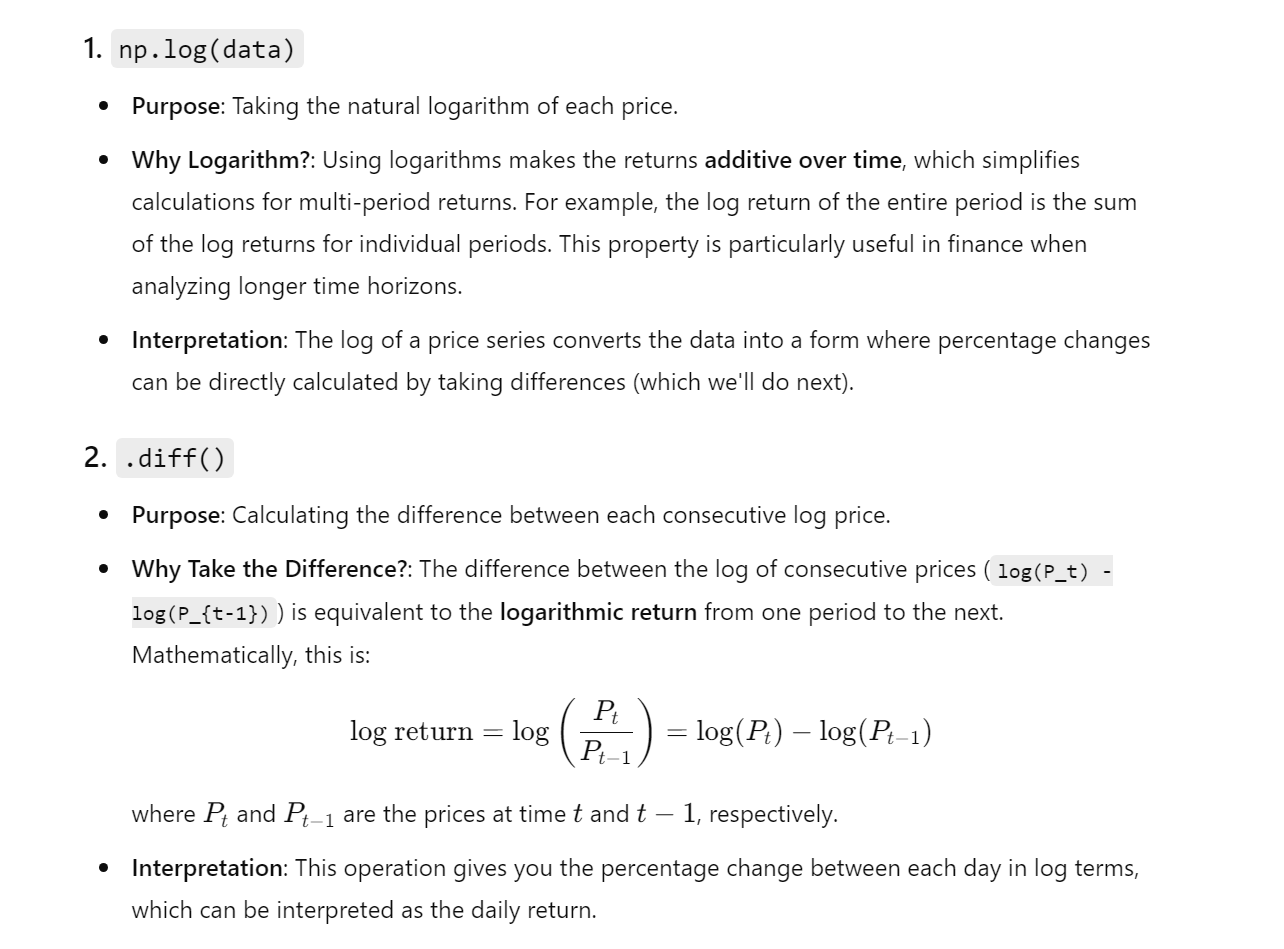

In [438]:
#huomaa että tämä laskee koko taulukolle logaritmisen tuoton. myöhemmässä vaiheessa
#sama koodi pelkästään yhdelle sarakkeelle:

#btc_data["log_returns"] = np.log(btc_data["Close"] / btc_data["Close"].shift(1))

returns = np.log(data).diff().dropna()

#voi laskea myös kumulatiivisen tuoton
cum = returns["SOL"].sum()
np.exp(cum) -1

In [440]:
returns.head()

,BTC,SOL
Date,,
2024-03-14,-0.023308,0.074914
2024-03-15,-0.026818,0.040494
2024-03-16,-0.062323,-0.010383
2024-03-17,0.046276,0.103293
2024-03-18,-0.011522,-0.029868


In [448]:
#korrelaatio

returns.sample(60).corr()

,BTC,SOL
BTC,1.000000,0.737052
SOL,0.737052,1.000000


### how much does y change when x changes

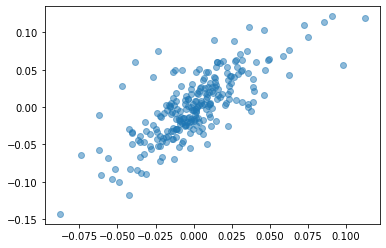

In [473]:
#tässä tapauksessa kuinka paljon y-akselin sol muuttuu kun x-akselin bitcoin muuttuu

plt.scatter(x=returns["BTC"], y=returns["SOL"], alpha=0.5)

In [474]:
reg = np.polyfit(returns["BTC"], returns["SOL"], deg=1)

In [475]:
reg

array([ 1.20072794e+00, -2.53509110e-05])

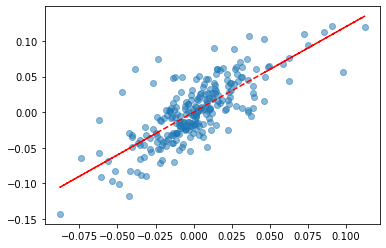

In [480]:
trend = np.polyval(reg, returns["BTC"])
plt.scatter(returns["BTC"], returns["SOL"], alpha=0.5)
plt.plot(returns["BTC"], trend, "r--")

## regression as a technical analysis 

In [483]:
btc_data = btc.copy()

In [486]:
time = np.arange(1, len(btc_data) +1)
btc_data["Time"] = time
btc_data = btc_data[["Time", "Close"]]
btc_data = round(btc_data, 2)

btc_data

In [497]:
reg = np.polyfit(btc_data["Time"], btc_data["Close"], deg=1)

In [498]:
reg

array([-2.08477313e+00,  6.49792818e+04])

In [503]:
trend = np.polyval(reg, btc_data["Time"])
std = btc_data["Close"].std()

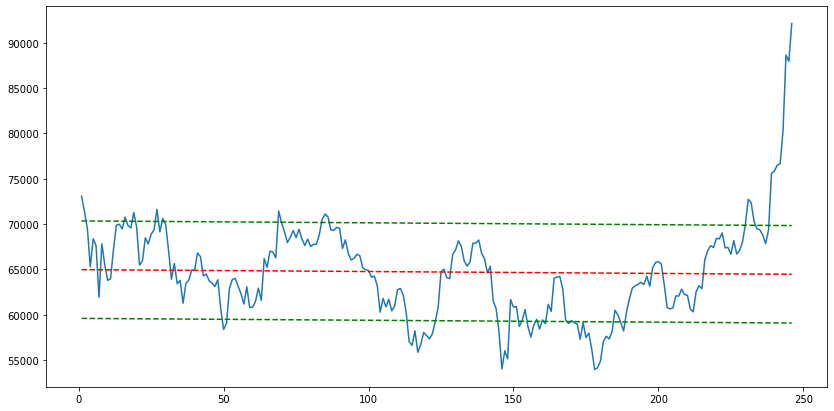

In [507]:
plt.figure(figsize=((14,7)))
plt.plot(btc_data["Time"],btc_data["Close"])
plt.plot(btc_data["Time"], trend, "r--")
plt.plot(btc_data["Time"], trend - std, "g--")
plt.plot(btc_data["Time"], trend + std, "g--")

# Calculate volatility

In [527]:
btc_data.drop("log_returns", axis=1, inplace=True)

In [528]:
btc_data["log_returns"] = np.log(btc_data["Close"] / btc_data["Close"].shift(1))

In [533]:
btc_data["Rolling_Volatility"] = btc_data["log_returns"].rolling(window=20).std() * np.sqrt(252)

Text(0.5, 1.0, 'Volatility')

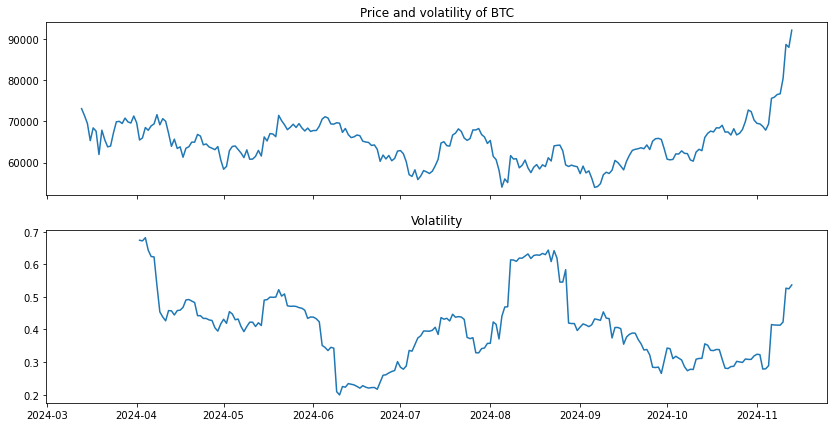

In [539]:
#Setting up the figure and two subplots
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,7), sharex=True)

ax1.plot(btc_data["Close"])
ax1.set_title("Price and volatility of BTC")

ax2.plot(btc_data["Rolling_Volatility"])
ax2.set_title("Volatility")

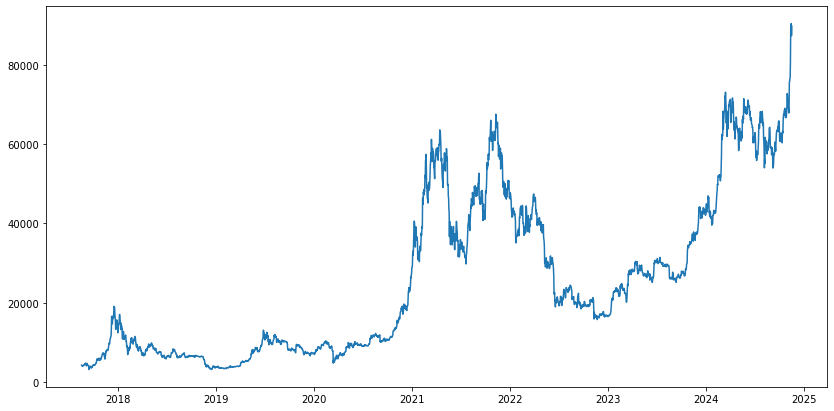

In [18]:
plt.figure(figsize=((14,7)))
plt.plot(btc["Close"]);

In [47]:
log_return = np.log(btc.loc["2024-01-01":].Close / btc.loc["2024-01-01":].Close.shift(1)).sum()
print(f"Log_return: {log_return}")
print(f"Log_return exponentiated: {np.exp(log_return)}")

Log_return: 0.7084762794700279
Log_return exponentiated: 2.0308943843927807


In [39]:
btc.loc["2024-11-15"]["Close"] / btc.loc["2024-01-01"]["Close"]

2.030894384392779

In [37]:
btc.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2024-11-11,80370.01,89530.54,80216.01,88647.99,82323.665776
2024-11-12,88648.00,89940.00,85072.00,87952.01,97299.887911
2024-11-13,87952.00,93265.64,86127.99,90375.20,86763.854127
2024-11-14,90375.21,91790.00,86668.21,87325.59,56729.510860
2024-11-15,87325.59,90709.74,87073.38,89724.00,21921.467410


In [40]:
btc.loc["2024-01-01":]

,Open,High,Low,Close,Volume
Date,,,,,
2024-01-01,42283.58,44184.10,42180.77,44179.55,27174.299030
2024-01-02,44179.55,45879.63,44148.34,44946.91,65146.406610
2024-01-03,44946.91,45500.00,40750.00,42845.23,81194.551730
2024-01-04,42845.23,44729.58,42613.77,44151.10,48038.063340
2024-01-05,44151.10,44357.46,42450.00,44145.11,48075.253270
...,...,...,...,...,...
2024-11-11,80370.01,89530.54,80216.01,88647.99,82323.665776
2024-11-12,88648.00,89940.00,85072.00,87952.01,97299.887911
2024-11-13,87952.00,93265.64,86127.99,90375.20,86763.854127


In [56]:
btc_slice = btc.loc["2024-01-02":]
btc_slice.groupby(btc_slice.index).agg({"Low": min, "High": max})

,Low,High
Date,,
2024-01-02,44148.34,45879.63
2024-01-03,40750.00,45500.00
2024-01-04,42613.77,44729.58
2024-01-05,42450.00,44357.46
2024-01-06,43397.05,44214.42
...,...,...
2024-11-11,80216.01,89530.54
2024-11-12,85072.00,89940.00
2024-11-13,86127.99,93265.64


## 1 hour level data munging 

.groupby() funktiolla pitää huomata, että data pitää olla yksilöityä. Alla esimerkissä jatkuvana ongelmana
on se, että groupby() funktiolla indexiä ryhmittäessä minuuttidata sotkee päivällä ryhmittely. Päiväyksestä pitää siis poistaa minuuttidarta niin, että päivän data on yksilöitävissä nimenomaan päivään, eikä päivän siäisiin minuutteihin. Muuten groupby ei toimi.

In [11]:
btc.groupby(btc.index).agg({"Low":min, "High":max})

,Low,High
Date,,
2024-01-01 00:00:00,42261.02,42554.57
2024-01-01 01:00:00,42431.65,42775.00
2024-01-01 02:00:00,42500.00,42638.41
2024-01-01 03:00:00,42230.08,42586.64
2024-01-01 04:00:00,42209.46,42399.99
...,...,...
2024-11-15 09:00:00,88024.40,89350.00
2024-11-15 10:00:00,88943.53,89458.13
2024-11-15 11:00:00,89138.94,89771.99


In [29]:
#tässä otsikon asia. Jos halutaan hakea päivittäisiä huippuja tai pohjia kellonajan pohjalta, niin näin edetään

btc_hourly_low = btc.loc[btc.groupby("TradeDate")["Low"].idxmin()]

In [77]:
btc_hourly_low["Hour"] = btc_hourly_low["Hour"].apply(lambda x: x.hour)
btc_hourly_low

,Low,TradeDate,Hour
Date,,,
2024-01-01 05:00:00,42180.77,2024-01-01,5
2024-01-02 00:00:00,44148.34,2024-01-02,0
2024-01-03 12:00:00,40750.00,2024-01-03,12
2024-01-04 01:00:00,42613.77,2024-01-04,1
2024-01-05 01:00:00,42450.00,2024-01-05,1
...,...,...,...
2024-11-11 00:00:00,80216.01,2024-11-11,0
2024-11-12 13:00:00,85072.00,2024-11-12,13
2024-11-13 06:00:00,86127.99,2024-11-13,6


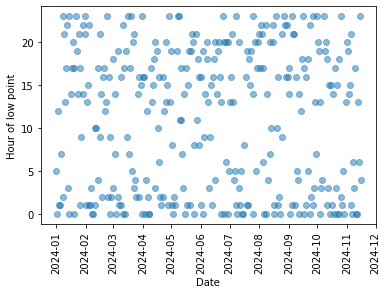

In [76]:

plt.scatter(btc_hourly_low.index,btc_hourly_low["Hour"], alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Hour of low point")
plt.xticks(rotation=90);

In [87]:
btc_hourly_low["Hour"].value_counts()


0     41
1     31
23    23
16    19
20    19
17    18
14    15
19    15
2     14
21    14
13    14
3     13
15    11
18    10
22    10
4      9
5      9
9      7
7      6
10     5
12     5
6      5
8      4
11     3
Name: Hour, dtype: int64

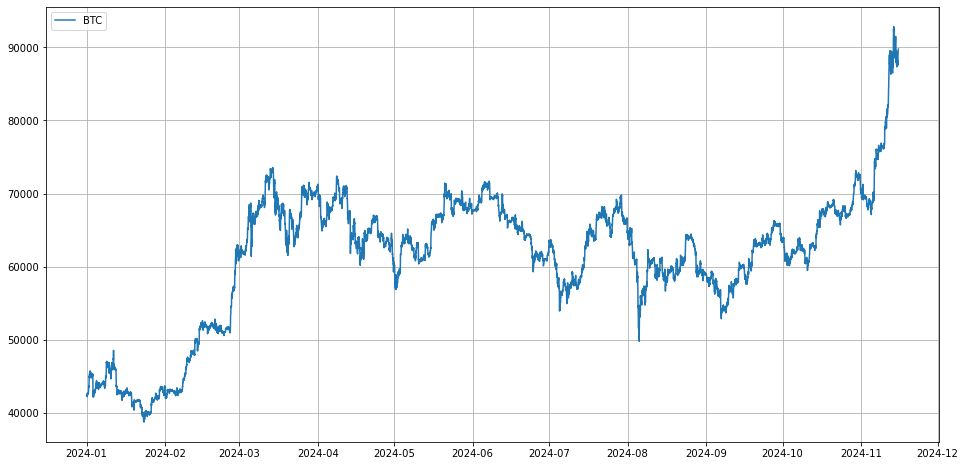

In [131]:
plt.figure(figsize=(16,8))
plt.plot(btc["Close"], label="BTC")
plt.grid(True)
plt.legend()